# Notebook 4: Modelos generativos

## Pre-requisitos

### Instalar paquetes

Si la práctica requiere algún paquete de Python, habrá que incluir una celda en la que se instalen. Si usamos un paquete que se ha utilizado en prácticas anteriores, podríamos dar por supuesto que está instalado pero no cuesta nada satisfacer todas las dependencias en la propia práctica para reducir las dependencias entre ellas.

In [1]:
# Ejemplo de instalación de tensorflow 2.0
#%tensorflow_version 2.x
# !pip3 install tensorflow  # NECESARIO SOLO SI SE EJECUTA EN LOCAL
import tensorflow as tf

# Hacemos los imports que sean necesarios
import numpy as np
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Modelos generativos sobre MNIST

Lo primero que tenemos que hacer es cargar el dataset.

In [2]:
labeled_data = 0.01 # Vamos a usar el etiquetado de sólo el 1% de los datos
np.random.seed(42)

(x_train, y_train), (x_test, y_test), = tf.keras.datasets.mnist.load_data()

indexes = np.arange(len(x_train))
np.random.shuffle(indexes)
ntrain_data = int(labeled_data*len(x_train))
unlabeled_train = x_train[indexes[ntrain_data:]]
x_train = x_train[indexes[:ntrain_data]] 
y_train = y_train[indexes[:ntrain_data]]

In [3]:
# TODO: Haz el preprocesado que necesites aquí (si lo necesitas)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2])) 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2])) /255
unlabeled_train = np.reshape(unlabeled_train, (unlabeled_train.shape[0], unlabeled_train.shape[1]*unlabeled_train.shape[2])) /255

one_hot_train = np.zeros((y_train.size, len(set(y_train))), dtype=int)
one_hot_train[np.arange(y_train.size), y_train ] = 1

one_hot_test = np.zeros((y_test.size, len(set(y_test))), dtype=int)
one_hot_test[np.arange(y_test.size), y_test ] = 1

## Modelo generativo

Vamos a crear nuestro propio modelo generativo. En clase de teoría has visto muchas versiones distintas:

1. Mezcla de distribuciones de Gaussianas (GMM)
1. Mezcla de distribuciones multinomiales (Naive Bayes)
1. Modelos de Markov ocultos (HMM)

Tal y como se os apunta en teoría, los modelos generativos abordan un problema más general, y aprenden realmente cómo se estructuran y distribuyen los datos de entrada. 

En nuestro caso, vamos a distribuír los datos de entrada mediante el uso de **Autoencoders**. 

# Autoencoders

El autoencoder es un tipo de red que se utiliza para aprender codificaciones eficientes de datos sin etiquetar (lo que se conoce como aprendizaje no supervisado). Es una red que tiene el mismo tamaño en la entrada como en la salida, puesto que el objetivo de la red es reconstruír la entrada con la menor pérdida posible.

Si lo que hacemos es reconstruír la entrada, ¿qué sentido tiene el usar la red? Habitualmente, **la red consta, a su mitad, de una capa con menos elementos que los datos de entrada**. Por tanto, al reconstruír los datos de la entrada a la salida, en esa capa tendremos una versión *comprimida* de la entrada, que contendrá la mayor parte de su información.

Por tanto, podemos dividir un autoencoder en 3 secciones diferentes, tal y como se ve en la siguiente figura:

![autoencoder](https://drive.google.com/uc?export=view&id=1yxkKZV0J0YplQAGPGJxQ2Z80Ad6L94eu)


1. **Encoder:** es la parte inicial de la red, encargada de comprimir los datos de la entrada.
1. **Code:** es la salida del encoder, contiene la versión *comprimida* de los datos de entrada.
1. **Decoder:** se encarga de, partiendo de la salida del *Encoder*, reconstruír la red.

## Crea tu propio Autoencoder

El diseño del autoencoder es libre (capas densas, convolucionales, ...), puedes crearlo como quieras. **El único requisito es que tiene que mantener los nombres (y parámetros) de las funciones descritas abajo.**

In [4]:
# TODO: crea tu propio autoencoder


class MiAutoencoder:

    def __init__(self, input_shape):
        
        self.input_shape = input_shape
        
        self.encoder = models.Sequential()
        self.encoder.add(layers.InputLayer(shape=self.input_shape))
        self.encoder.add(layers.Dense(512, activation='relu'))
        self.encoder.add(layers.Dense(128, activation='relu'))
        self.encoder.add(layers.Dense(64, activation='relu'))
        self.encoder.add(layers.Dense(32, activation='relu'))
        self.encoder.add(layers.Dense(32, activation='relu'))  # Latent space

        self.decoder = models.Sequential()
        self.decoder.add(layers.InputLayer(shape=(32,)))
        self.decoder.add(layers.Dense(32, activation='relu'))
        self.decoder.add(layers.Dense(64, activation='relu'))
        self.decoder.add(layers.Dense(128, activation='relu'))
        self.decoder.add(layers.Dense(512, activation='relu'))
        self.decoder.add(layers.Dense(self.input_shape[0], activation='sigmoid'))  # Output should match input

        self.autoencoder = models.Sequential([self.encoder, self.decoder])

        self.optimicer = tf.keras.optimizers.AdamW(
            learning_rate=0.001,
            clipnorm=1,
        )


        self.autoencoder.compile(optimizer=self.optimicer, loss='mse')
    
    def fit(self, X, y=None, sample_weight=None, batch_size=60_000, epochs=100):
        # TODO: entrena el modelo. Escoge el tamaño de batch y el número de epochs que quieras
        
        self.autoencoder.fit(X, X, 
                             batch_size=batch_size, 
                             epochs=epochs, 
                             sample_weight=sample_weight)

    def get_encoded_data(self, X):
        # TODO: devuelve la salida del encoder (code)
        return self.encoder.predict(X)


    def __call__(self, X):
        return self.autoencoder.predict(X)
        
    def __del__(self):
        # elimina todos los modelos que hayas creado
        tf.keras.backend.clear_session() # Necesario para liberar la memoria en GPU

## Crea tu propio Clasificador

El diseño del clasificador es libre, pero recuerda que tiene que ser simple (máximo dos capas). **El único requisito es que tiene que mantener los nombres (y parámetros) de las funciones descritas abajo.**

In [5]:
# TODO: crea tu propio clasificador

class MiClasificador:

    def __init__(self):
        # TODO : define el modelo y compílalo
        
        self.input_shape = (32,)
        
        self.classifier = models.Sequential()
        self.classifier.add(layers.InputLayer(shape=self.input_shape))
        self.classifier.add(layers.Dense(32, activation='relu'))
        self.classifier.add(layers.Dense(10, activation='sigmoid'))

        self.optimicer = tf.keras.optimizers.AdamW(
            learning_rate=0.001,
            clipnorm=1,
        )

        self.classifier.compile(optimizer=self.optimicer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    def fit(self, X, y, sample_weight=None, batch_size=60_000, epochs=350):
        # TODO: entrena el modelo. Escoge el tamaño de batch y el número de epochs que quieras
        self.classifier.fit(X, y, 
                             batch_size=batch_size, 
                             epochs=epochs, 
                             sample_weight=sample_weight)

    def predict(self, X):
        # TODO: devuelve la clase ganadora

        return np.argmax(self.predict_proba(X)) + 1
    
    def predict_proba(self, X):
        
        return self.classifier.predict(X)
    
    def score(self, X, y):
        
        return self.classifier.evaluate(X, y)[1]

    def __del__(self):
        # elimina todos los modelos que hayas creado
        tf.keras.backend.clear_session() # Necesario para liberar la memoria en GPU

### Entrenamiendo del modelo semisupervisado

El entrenamiento del sistema semisupervisado se realiza en dos pasos.

1. Se entrena el autoencoder con todos los datos (etiquetados y sin etiquetar).
1. Se entrena un clasificador simple (una o dos capas), teniendo como entrada la salida del encoder (**code**) de los datos etiquetados.

<font color='red'>NOTA:</font> para entrenar (y predecir) vamos a utilizar los nombres de las funciones que hemos definido en el autoencoder y en el clasificador.

In [6]:
# TODO: implementa el algoritmo semisupervised_training.

def semisupervised_training(autoencoder, classifier, x_train, y_train, unlabeled_data):

    all_x = np.vstack((x_train, unlabeled_train))
    autoencoder.fit(all_x)
    x_coded = autoencoder.get_encoded_data(x_train)
    classifier.fit(x_coded, y_train)

### Entrenamos nuestro modelo

Usa lo hecho anteriormente para entrenar tu clasificador de una manera semi-supervisada.

In [7]:
# Crea tu autoencoder y tu clasificador

autoencoder = MiAutoencoder(input_shape=x_train[0].shape)
classifier = MiClasificador()

2025-03-31 23:36:17.458837: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-31 23:36:17.458919: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-31 23:36:17.458948: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-31 23:36:17.458987: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-31 23:36:17.459016: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
# TODO: Entrena tu modelo

semisupervised_training(autoencoder=autoencoder, classifier=classifier, x_train=x_train, y_train=one_hot_train, unlabeled_data=unlabeled_train)

Epoch 1/100


2025-03-31 23:36:21.935447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 71.5394
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step - loss: 71.4639
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - loss: 71.3724
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - loss: 71.2990
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - loss: 71.2545
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - loss: 71.2296
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - loss: 71.2136
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - loss: 71.2041
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - loss: 71.1965
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step - loss: 71.1943
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 71.1877
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - loss: 71.1811
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - loss: 71.1793
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - loss: 71.1788
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 71.1721
Epoc

In [112]:
# TODO: Obtén la precisión sobre el conjunto de test
pred_data = autoencoder.get_encoded_data(x_test)
print('Test accuracy :', classifier.score(pred_data, one_hot_test))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7033 - loss: 0.9042
Test accuracy : 0.730400025844574


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


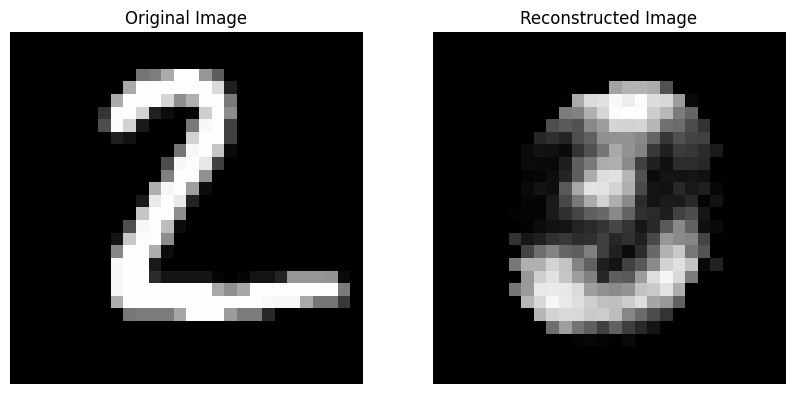

In [120]:
import matplotlib.pyplot as plt

index = 1

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(x_test[index].reshape(28, 28), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off') 

# Get the reconstructed image from the autoencoder
reconstructed_image = autoencoder(x_test[index].reshape(1, 784)).reshape(28, 28)

# Plot the reconstructed image on the right
axes[1].imshow(reconstructed_image, cmap='gray')
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')

# Display the plot
plt.show()

## Mejorando el código

nuestro modelo actual requiere de dos pasos para entrenarse, pero podría realizarse en un único paso si **creamos un modelo con las dos salidas (autoencoder y clasificador)**. 

Para ello, hay que tener en cuenta que, en los datos sin etiquetar, su contribución al clasificador debería ser nula.


### TRABAJO: Crea el nuevo modelo y modifica la función semisupervised_training para tener en cuenta todos los puntos mencionados anteriormente

In [190]:
# TODO: crea el nuevo modelo

# TODO: crea tu propio clasificador

class MiClasificadorSemisupervisado:

    def __init__(self, input_shape):
        # TODO : define el modelo y compílalo
        
        self.input_shape = input_shape
        self.num_classes = 10
        
        input_layer = layers.Input(shape=self.input_shape)
        
        # Encoder part (shared for both autoencoder and classifier)
        encoded = layers.Dense(128, activation='relu')(input_layer)
        encoded = layers.Dense(64, activation='relu')(encoded)
        encoded = layers.Dense(16, activation='relu', kernel_regularizer='l2')(encoded)
        
        # Decoder for autoencoder part
        decoded = layers.Dense(64, activation='relu')(encoded)
        decoded = layers.Dense(128, activation='relu')(decoded)
        decoded = layers.Dense(self.input_shape[0], activation='sigmoid',name='autoencoder')(decoded)

        # Classifier part
        classifier = layers.Dense(32, activation='relu')(encoded)
        classifier = layers.Dense(16, activation='relu')(classifier)
        classifier_output = layers.Dense(self.num_classes, activation='softmax',name='classifier')(classifier)

        # Autoencoder model (for reconstructing input)
        self.autoencoder = models.Model(input_layer, decoded)
        #self.autoencoder.compile(optimizer='adam', loss='mse')
        
        # Classifier model (for predicting class labels)
        self.classifier = models.Model(input_layer, classifier_output)
        #self.classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        
        
        # Combined model with two outputs: one for autoencoder (reconstruction) and one for classifier (classification)
        self.model = models.Model(input_layer, 
                                  [decoded, classifier_output])
                                  #classifier_output)

        self.optimicer = tf.keras.optimizers.AdamW(
            learning_rate=0.0001,
            clipnorm=1,
        )
        
        self.model.compile(optimizer=self.optimicer,
                           loss=['mse', 'categorical_crossentropy'],
                           #loss='categorical_crossentropy',
                           loss_weights=[.8, 1.2],  # Adjust loss weights if needed
                           metrics=['accuracy', 'accuracy'])
    
    def fit(self, X, y, unlabeled_data, batch_size,  epochs):
        # TODO: entrena el modelo. Escoge el tamaño de batch y el número de epochs que quieras, y define bien el sample_weight

        all_x = np.vstack((X, unlabeled_train))
        y_zeros = np.zeros((unlabeled_data.shape[0],y.shape[1]))
        all_y = np.vstack((y,y_zeros))
        weight_autoencoder = np.ones(len(all_x))
        weight_classifier = np.array([1]*len(X) + [0]*len(unlabeled_data))
        
        h = self.model.fit(all_x, 
                       [all_x, all_y], 
                       #all_y,
                       sample_weight=[weight_autoencoder, weight_classifier], 
                       #sample_weight=sample_weight,
                       epochs=epochs, 
                       batch_size=batch_size, 
                       verbose=1)
        return h

    def predict(self, X):
        # TODO: devuelve la clase ganadora del clasificador
        _, predictions = self.model.predict(X)
        return predictions.argmax(axis=1)
    
    def predict_proba(self, X):
        # TODO: devuelve la probabilidad del clasificador
        _, predictions = self.model.predict(X)
        return predictions
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def __call__(self, X):
        return self.autoencoder.predict(X), self.classifier.predict(X)

    def __del__(self):
        # elimina todos los modelos que hayas creado
        tf.keras.backend.clear_session() # Necesario para liberar la memoria en GPU

In [197]:
# TODO: reescribe la función semisupervised_training para incorporar las mejoras mencionadas anteriormente

model = MiClasificadorSemisupervisado(input_shape=x_train[0].shape)

def semisupervised_training_v2(model, x_train, y_train, unlabeled_data):
    h = model.fit(x_train, y_train, unlabeled_data, batch_size=60_000, epochs = 1000)
    return h

In [198]:
# TODO: Crea y entrena tu clasificador

model = MiClasificadorSemisupervisado(input_shape=x_train[0].shape)

h = semisupervised_training_v2(model, x_train, one_hot_train, unlabeled_train)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - autoencoder_accuracy: 0.0017 - autoencoder_loss: 0.2327 - classifier_accuracy: 0.0037 - classifier_loss: 0.0247 - loss: 0.4767
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - autoencoder_accuracy: 0.0018 - autoencoder_loss: 0.2324 - classifier_accuracy: 0.0038 - classifier_loss: 0.0246 - loss: 0.4761
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - autoencoder_accuracy: 0.0017 - autoencoder_loss: 0.2320 - classifier_accuracy: 0.0039 - classifier_loss: 0.0245 - loss: 0.4754
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - autoencoder_accuracy: 0.0018 - autoencoder_loss: 0.2317 - classifier_accuracy: 0.0036 - classifier_loss: 0.0244 - loss: 0.4748
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - autoencoder_accuracy: 0.0019 - autoencoder_loss: 0.2314 - classifier_accuracy: 0.0037 - classifier_loss: 0.0244 - loss: 0.4742
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - autoencoder_accuracy: 0.0018 - autoencoder_l

In [199]:
# TODO: Obtén la precisión sobre el conjunto de test
print('Test accuracy :', model.score(x_test, y_test))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Test accuracy : 0.816


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


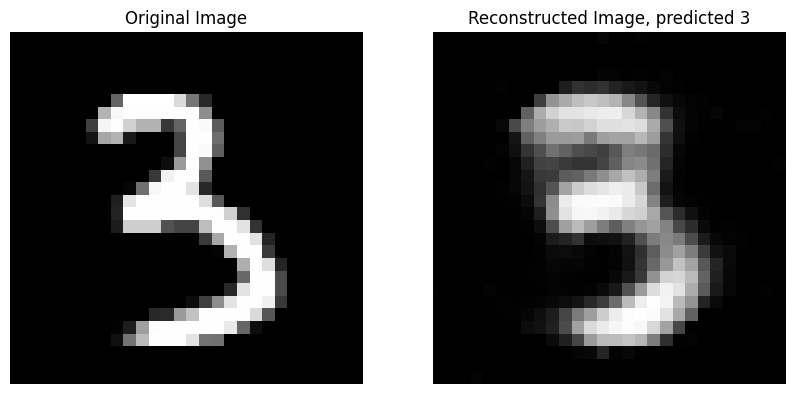

In [210]:
import matplotlib.pyplot as plt

index = 32

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(x_test[index].reshape(28, 28), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off') 

# Get the reconstructed image from the autoencoder
reconstructed_image, label = model(x_test[index].reshape(1, 784))

# Plot the reconstructed image on the right
axes[1].imshow(reconstructed_image.reshape(28, 28), cmap='gray')
axes[1].set_title(f"Reconstructed Image, predicted {np.argmax(label)}")
axes[1].axis('off')

# Display the plot
plt.show()

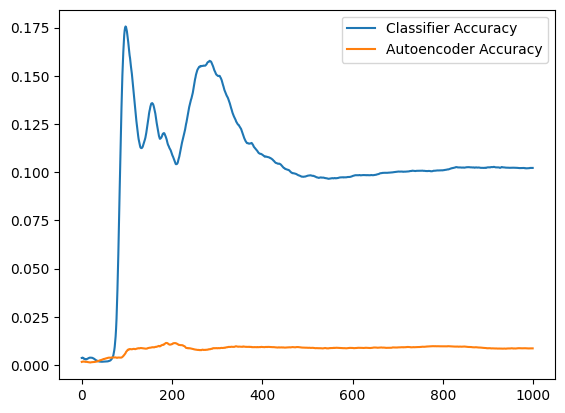

In [201]:
import matplotlib.pyplot as plt

plt.plot(h.history['classifier_accuracy'], label='Classifier Accuracy')
plt.plot(h.history['autoencoder_accuracy'], label='Autoencoder Accuracy')
plt.legend()
plt.show()

# Hay vida más allá del autoencoder

¿Has probado a utilizar otro método distinto del autoencoder para obtener una respresentación similar a la salida del encoder? La idea es la siguiente:

1. Define un modelo $model$ convolucional similar al encoder de un autoencoder (la entrada es el tamaño de la imagen, la salida el vector de representación)
1. Define una capa de salida $cluster$ que, partiendo de la salida de model, nos devuelva una salida con el mismo número de clases que el dataset a utilizar (la entrada es el vector de representación), usando softmax como activación de salida
1. Para cada batch de entrenamiento $X$:  # Usa un batch alto, mínimo 128
  1. Modifica las imágenes de entrada con [data_augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=es-419), llámala $augX_1$.
  1. Modifica otra vez las imágenes de entrada con [data_augmentation_2](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=es-419), llámala $augX_2$.
  1. $augX_{1comp} \leftarrow model(augX_1)$
  1. $augX_{2comp} \leftarrow model(augX_2)$
  1. $cX_{1comp} \leftarrow cluster(augX_{1comp})$
  1. $cX_{2comp} \leftarrow cluster(augX_{2comp})$
  1. $M \leftarrow augX_{1comp} ~ augX_{2comp}^T$
  1. $loss_C \leftarrow cX_{1comp}(1 - cX_{1comp}) + cX_{2comp}(1 - cX_{2comp})$ # Puede que tengas que crear tu [propia función de coste](https://keras.io/api/losses/#creating-custom-losses)
  1. $loss_M \leftarrow crossentropy(I, softmax(M/\tau, axis=1)))$ # Puede que tengas que crear tu [propia función de coste](https://keras.io/api/losses/#creating-custom-losses)
  1. $\tau$ es un hiperparámetro que se suele definir a 5.0
  1. $loss \leftarrow loss_M + \lambda~loss_C$
    1. $\lambda$ es un hiperparámetro (puedes probar con 0.5)


In [41]:
# Escribe aquí la solución. Crea tantos bloques de código como necesites. Puedes utilizar la siguiente red para generar distorsiones


class ContrastiveLoss():
    def __init__(self, temperature=0.5):
        self.temperature = temperature
        
    def __call__(self, M):
        # y_true es la matriz identidad (no la usamos directamente)
        # y_pred es la matriz de similitud M
        
        # Aplicamos softmax con temperatura
        logits = M / self.temperature
        logits_max = tf.reduce_max(logits, axis=1, keepdims=True)
        logits = logits - logits_max
        exp_logits = tf.exp(logits)
        exp_logits_sum = tf.reduce_sum(exp_logits, axis=1, keepdims=True)
        probs = exp_logits / exp_logits_sum # softmax
        
        # Creamos matriz identidad como objetivo
        batch_size = tf.shape(M)[0]
        I = tf.eye(batch_size)

        # Seleccionamos las probabilidades de la clase correcta (diagonal de y_true)
        correct_class_probs = tf.matmul(I, probs)   
        # Calculamos entropia cruzada
        loss = -tf.reduce_mean(tf.math.log(correct_class_probs + 1e-10))
        
        return loss

# Función de pérdida para el clustering
class ClusteringLoss():
    def __init__(self):
        pass
    def __call__(self, cX_1comp, cX_2comp):

        # loss_C = cX_1comp(1 - cX_1comp) + cX_2comp(1 - cX_2comp)
        loss_1 = tf.reduce_mean(cX_1comp * (1 - cX_1comp))
        loss_2 = tf.reduce_mean(cX_2comp * (1 - cX_2comp))
        
        return loss_1 + loss_2


class ContrastiveModel():
    def __init__(self, input_shape, lambda_param = 0.5, temperature = 0.5, learning_rate=0.0005):

        self.lambda_param = lambda_param
        self.contrastive_loss = ContrastiveLoss(temperature=temperature)
        self.clustering_loss = ClusteringLoss()
        self.optimicer = tf.keras.optimizers.AdamW(
            learning_rate=learning_rate,
            clipnorm=1,
        )

        self.data_augmentation_1 = tf.keras.models.Sequential([
                # tf.keras.layers.RandomFlip("horizontal"),  # Puede ser util en otros casos
                tf.keras.layers.RandomRotation(0.05),
                tf.keras.layers.RandomTranslation(0.15, 0.15),
                tf.keras.layers.RandomZoom(.15),
            ])
    
        self.data_augmentation_2 = tf.keras.models.Sequential([
                # tf.keras.layers.RandomFlip("horizontal"),  # Puede ser util en otros casos
                tf.keras.layers.RandomTranslation(0.15, 0.15),
                tf.keras.layers.RandomRotation(.2)
                #tf.keras.layers.Resizing(40, 40), # para CIFAR, para MNIST usar 40 en lugar de 48
                #tf.keras.layers.RandomCrop(28, 28), # para CIFAR, para MNIST usar 28 en lugar de 32
            ])
            
        # Definir modelo convolucional
        input_layer = tf.keras.layers.Input(batch_shape=(None, 28, 28,1))  # Tamaño de imagen
        conv_layer = tf.keras.layers.Conv2D(8, (3, 3), activation='relu')(input_layer)
        conv_layer = tf.keras.layers.Conv2D(8, (3, 3), activation='relu')(conv_layer)
        conv_layer = tf.keras.layers.Conv2D(8, (3, 3), activation='relu')(conv_layer)
        conv_layer = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(conv_layer)
        conv_layer = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(conv_layer)
        flatten_layer = tf.keras.layers.Flatten()(conv_layer)
        
        # Capa de clustering
        cluster_layer = tf.keras.layers.Dense(10, activation='softmax')(flatten_layer)
        
        # Modelo final
        self.encoder = tf.keras.Model(input_layer, outputs=flatten_layer)
        self.cluster = tf.keras.Model(flatten_layer, outputs=cluster_layer)
        
        #model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    
    def train_step(self, data):
        if isinstance(data, tuple):
            X = data[0]
        else:
            X = data
            
        batch_size = tf.shape(X)[0]
        
        # Aplicar las dos transformaciones de data augmentation
        augX_1 = self.data_augmentation_1(X)
        augX_2 = self.data_augmentation_2(X)
        
        with tf.GradientTape() as tape:
            #print(f'< 1 {augX_1.shape}, 2 {augX_2.shape}')
            # Obtener representaciones del encoder
            augX_1comp = self.encoder(augX_1)
            #augX_1comp = self.encoder(X)
            augX_2comp = self.encoder(augX_2)
            #augX_2comp = self.encoder(X)
            #print(f'<< 1 {augX_1comp.shape}, 2 {augX_2comp.shape}')
            # Obtener salidas del clustering
            #augX_1comp = tf.keras.layers.Flatten('channels_last')(augX_1comp)
            cX_1comp = self.cluster(augX_1comp)
            cX_2comp = self.cluster(augX_2comp)

            
            # Calcular matriz de similitud M
            M = tf.matmul(augX_1comp, augX_2comp, transpose_b=True)
            #print(f'm {M.shape}, 1 {augX_1comp.shape}, 2 {augX_2comp.shape}')
            
            plt.imshow(M.numpy())
            
            # Calcular pérdida de contraste
            loss_M = self.contrastive_loss(M)
            
            # Calcular pérdida de clustering
            loss_C = self.clustering_loss(cX_1comp, cX_2comp)
            
            # Pérdida total
            total_loss = loss_M + self.lambda_param * loss_C
            
        # Calcular gradientes y actualizar pesos
        gradients = tape.gradient(total_loss, self.cluster.trainable_variables)
        self.optimicer.apply_gradients(zip(gradients, self.cluster.trainable_variables))
        
        return {"loss": total_loss, "contrastive_loss": loss_M, "clustering_loss": loss_C}

    def mini_batches(self, X, batch_size):
        for start in range(0, X.shape[0], batch_size):
            # Yield each mini-batch
            end = min(start + batch_size, X.shape[0])
            yield X[start:end]

    def train(self, dataset, epochs=10, batch_size=128):
        for epoch in range(epochs):
            total_loss = 0
            for data in self.mini_batches(dataset, batch_size=batch_size):
                loss_dict = self.train_step(data)
                total_loss += loss_dict["loss"]
            
           
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_dict["loss"]}")

    def __call__(self, X):
        return self.encoder.predict(X), self.clusters.predict(X)

In [12]:
class ContrastiveLoss():
    def __init__(self, temperature=0.5):
        self.temperature = temperature
        
    def __call__(self, M):
        # y_true es la matriz identidad (no la usamos directamente)
        # y_pred es la matriz de similitud M
        
        # Aplicamos softmax con temperatura
        logits = M / self.temperature
        logits_max = tf.reduce_max(logits, axis=1, keepdims=True)
        logits = logits - logits_max
        exp_logits = tf.exp(logits)
        exp_logits_sum = tf.reduce_sum(exp_logits, axis=1, keepdims=True)
        probs = exp_logits / exp_logits_sum # softmax
        
        # Creamos matriz identidad como objetivo
        batch_size = tf.shape(M)[0]
        I = tf.eye(batch_size)
        # Seleccionamos las probabilidades de la clase correcta (diagonal de y_true)
        correct_class_probs = tf.matmul(I, probs)   
        # Calculamos entropia cruzada
        loss = -tf.reduce_mean(tf.math.log(correct_class_probs + 1e-10))
        
        return loss

# Función de pérdida para el clustering
class ClusteringLoss():
    def __init__(self):
        pass
    def __call__(self, cX_1comp, cX_2comp):
        # loss_C = cX_1comp(1 - cX_1comp) + cX_2comp(1 - cX_2comp)
        loss_1 = tf.reduce_mean(cX_1comp * (1 - cX_1comp))
        loss_2 = tf.reduce_mean(cX_2comp * (1 - cX_2comp))
        
        return loss_1 + loss_2

class ContrastiveModel():
    def __init__(self, input_shape, lambda_param = 0.5, temperature = 0.5, learning_rate=0.0005):
        self.lambda_param = lambda_param
        self.contrastive_loss = ContrastiveLoss(temperature=temperature)
        self.clustering_loss = ClusteringLoss()
        self.optimicer = tf.keras.optimizers.AdamW(
            learning_rate=learning_rate,
            clipnorm=1,
        )
        self.data_augmentation_1 = tf.keras.models.Sequential([
                # tf.keras.layers.RandomFlip("horizontal"),  # Puede ser util en otros casos
                tf.keras.layers.RandomRotation(0.05),
                tf.keras.layers.RandomTranslation(0.15, 0.15),
                tf.keras.layers.RandomZoom(.15),
            ])
    
        self.data_augmentation_2 = tf.keras.models.Sequential([
                # tf.keras.layers.RandomFlip("horizontal"),  # Puede ser util en otros casos
                tf.keras.layers.RandomTranslation(0.15, 0.15),
                tf.keras.layers.RandomRotation(.2),
                tf.keras.layers.Resizing(40, 40), # para CIFAR, para MNIST usar 40 en lugar de 48
                tf.keras.layers.RandomCrop(28, 28), # para CIFAR, para MNIST usar 28 en lugar de 32
            ])
            
        # Definir modelo convolucional
        input_layer = tf.keras.layers.Input(batch_shape=(None, 28, 28,1))  # Tamaño de imagen
        conv_layer = tf.keras.layers.Conv2D(8, (3, 3), activation='relu')(input_layer)
        conv_layer = tf.keras.layers.Conv2D(8, (3, 3), activation='relu')(conv_layer)
        conv_layer = tf.keras.layers.Conv2D(8, (3, 3), activation='relu')(conv_layer)
        conv_layer = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(conv_layer)
        conv_layer = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(conv_layer)
        flatten_layer = tf.keras.layers.Flatten()(conv_layer)
        
        # Capa de clustering
        cluster_layer = tf.keras.layers.Dense(10, activation='softmax')(flatten_layer)
        
        # Modelo final
        self.encoder = tf.keras.Model(input_layer, outputs=flatten_layer)
        self.cluster = tf.keras.Model(flatten_layer, outputs=cluster_layer)
        
        # Historial de pérdidas para graficar
        self.loss_history = {
            'total_loss': [],
            'contrastive_loss': [],
            'clustering_loss': []
        }
        
        #model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    def train_step(self, data):
        if isinstance(data, tuple):
            X = data[0]
        else:
            X = data
            
        batch_size = tf.shape(X)[0]
        
        # Aplicar las dos transformaciones de data augmentation
        augX_1 = self.data_augmentation_1(X)
        augX_2 = self.data_augmentation_2(X)
        
        with tf.GradientTape() as tape:
            #print(f'< 1 {augX_1.shape}, 2 {augX_2.shape}')
            # Obtener representaciones del encoder
            augX_1comp = self.encoder(augX_1)
            #augX_1comp = self.encoder(X)
            augX_2comp = self.encoder(augX_2)
            #augX_2comp = self.encoder(X)
            #print(f'<< 1 {augX_1comp.shape}, 2 {augX_2comp.shape}')
            # Obtener salidas del clustering
            #augX_1comp = tf.keras.layers.Flatten('channels_last')(augX_1comp)
            cX_1comp = self.cluster(augX_1comp)
            cX_2comp = self.cluster(augX_2comp)
            
            # Calcular matriz de similitud M
            M = tf.matmul(augX_1comp, augX_2comp, transpose_b=True)
            #print(f'm {M.shape}, 1 {augX_1comp.shape}, 2 {augX_2comp.shape}')
            
            # Calcular pérdida de contraste
            loss_M = self.contrastive_loss(M)
            
            # Calcular pérdida de clustering
            loss_C = self.clustering_loss(cX_1comp, cX_2comp)
            
            # Pérdida total
            total_loss = loss_M + self.lambda_param * loss_C
            
        # Calcular gradientes y actualizar pesos
        gradients = tape.gradient(total_loss, self.encoder.trainable_variables + self.cluster.trainable_variables)
        self.optimicer.apply_gradients(zip(gradients, self.encoder.trainable_variables + self.cluster.trainable_variables))
        
        return {"loss": total_loss, "contrastive_loss": loss_M, "clustering_loss": loss_C}
    
    def mini_batches(self, X, batch_size):
        for start in range(0, X.shape[0], batch_size):
            # Yield each mini-batch
            end = min(start + batch_size, X.shape[0])
            yield X[start:end]
    
    def train(self, dataset, epochs=10, batch_size=128):
        # Reiniciar el historial de pérdida si comenzamos un nuevo entrenamiento
        self.loss_history = {
            'total_loss': [],
            'contrastive_loss': [],
            'clustering_loss': []
        }
        
        for epoch in range(epochs):
            epoch_total_loss = 0
            epoch_contrastive_loss = 0
            epoch_clustering_loss = 0
            batch_count = 0
            
            for data in self.mini_batches(dataset, batch_size=batch_size):
                loss_dict = self.train_step(data)
                epoch_total_loss += loss_dict["loss"]
                epoch_contrastive_loss += loss_dict["contrastive_loss"]
                epoch_clustering_loss += loss_dict["clustering_loss"]
                batch_count += 1
            
            # Calcular promedios para la época
            avg_total_loss = epoch_total_loss / batch_count
            avg_contrastive_loss = epoch_contrastive_loss / batch_count
            avg_clustering_loss = epoch_clustering_loss / batch_count
            
            # Guardar en el historial
            self.loss_history['total_loss'].append(avg_total_loss.numpy())
            self.loss_history['contrastive_loss'].append(avg_contrastive_loss.numpy())
            self.loss_history['clustering_loss'].append(avg_clustering_loss.numpy())
            
            print(f"Epoch {epoch+1}/{epochs}, Total Loss: {avg_total_loss:.4f}, "
                  f"Contrastive Loss: {avg_contrastive_loss:.4f}, "
                  f"Clustering Loss: {avg_clustering_loss:.4f}")
    
    def plot_training_history(self, figsize=(12, 6)):
        """
        Visualiza el historial de pérdidas durante el entrenamiento.
        """
        import matplotlib.pyplot as plt
        
        epochs = range(1, len(self.loss_history['total_loss']) + 1)
        
        plt.figure(figsize=figsize)
        
        # Gráfico de pérdida total
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.loss_history['total_loss'], 'b-', label='Total Loss')
        plt.title('Total Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        
        # Gráfico comparativo de pérdidas
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.loss_history['contrastive_loss'], 'r-', label='Contrastive Loss')
        plt.plot(epochs, self.loss_history['clustering_loss'], 'g-', label='Clustering Loss')
        plt.title('Component Losses')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def __call__(self, X):
        features = self.encoder(X)
        clusters = self.cluster(features)
        return features, clusters

    def plot_similarity_matrix(self, X, n_samples=10):
        """
        Visualiza la matriz de similitud para un conjunto de muestras.
        """
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Seleccionar n_samples aleatorias
        if n_samples < X.shape[0]:
            indices = np.random.choice(X.shape[0], n_samples, replace=False)
            samples = X[indices]
        else:
            samples = X
            
        # Aplicar data augmentation
        augX_1 = self.data_augmentation_1(samples)
        augX_2 = self.data_augmentation_2(samples)
        
        # Obtener representaciones
        augX_1comp = self.encoder(augX_1)
        augX_2comp = self.encoder(augX_2)
        
        # Calcular matriz de similitud
        M = tf.matmul(augX_1comp, augX_2comp, transpose_b=True).numpy()
        
        # Visualizar
        plt.figure(figsize=(8, 8))
        plt.imshow(M, cmap='viridis')
        plt.colorbar()
        plt.title('Similarity Matrix')
        plt.xlabel('Augmentation 2')
        plt.ylabel('Augmentation 1')
        plt.tight_layout()
        plt.show()
        
        return M

In [13]:
labeled_data = 0.01 # Vamos a usar el etiquetado de sólo el 1% de los datos
np.random.seed(42)

(x_train, y_train), (x_test, y_test), = tf.keras.datasets.mnist.load_data()

indexes = np.arange(len(x_train))
np.random.shuffle(indexes)
ntrain_data = int(labeled_data*len(x_train))
unlabeled_train = x_train[indexes[ntrain_data:]]
x_train = x_train[indexes[:ntrain_data]] 
y_train = y_train[indexes[:ntrain_data]]


# TODO: Haz el preprocesado que necesites aquí (si lo necesitas)

x_train = x_train /255
x_test = x_test /255
unlabeled_train = unlabeled_train /255

one_hot_train = np.zeros((y_train.size, len(set(y_train))), dtype=int)
one_hot_train[np.arange(y_train.size), y_train ] = 1

one_hot_test = np.zeros((y_test.size, len(set(y_test))), dtype=int)
one_hot_test[np.arange(y_test.size), y_test ] = 1

In [14]:
cModel = ContrastiveModel(unlabeled_train[0].shape, learning_rate=0.0001, lambda_param=50)
#unlabeled_train = np.expand_dims(unlabeled_train, axis=-1)
cModel.train(unlabeled_train, epochs=20, batch_size=2048)
cModel.plot_training_history()

Epoch 1/20, Total Loss: 12.3638, Contrastive Loss: 3.3655, Clustering Loss: 0.1800
Epoch 2/20, Total Loss: 12.3147, Contrastive Loss: 3.3334, Clustering Loss: 0.1796
Epoch 3/20, Total Loss: 11.9474, Contrastive Loss: 3.3784, Clustering Loss: 0.1714
Epoch 4/20, Total Loss: 11.1642, Contrastive Loss: 3.3793, Clustering Loss: 0.1557


KeyboardInterrupt: 

In [61]:
n_samples = 100
test_samples = x_test[:n_samples].reshape(n_samples,28,28,1)

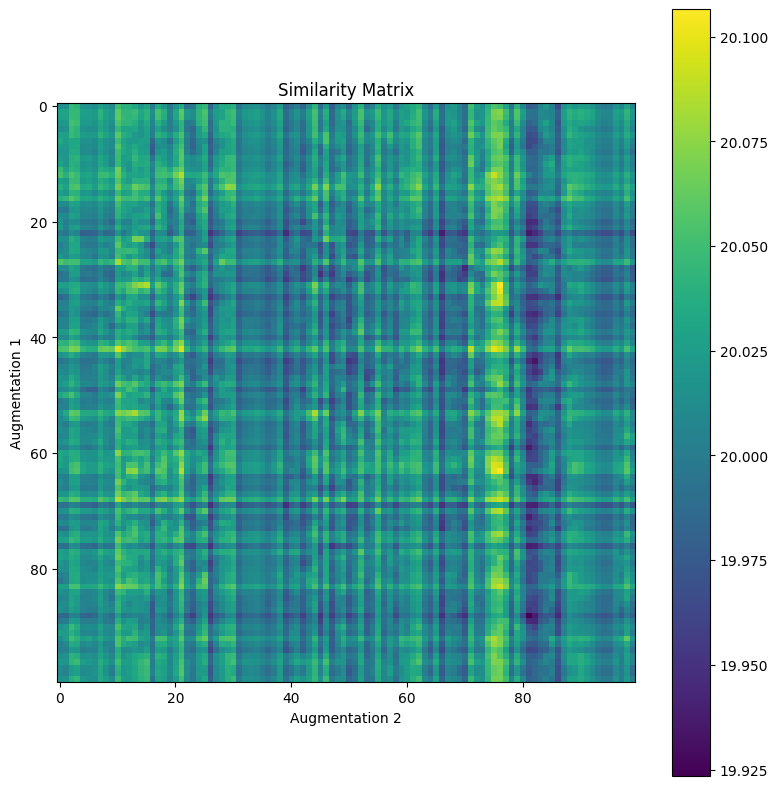

In [84]:
cModel.plot_similarity_matrix(test_samples, n_samples=n_samples);

# Trabajo extra

¿Has probado a hacer el autoencoder totalmente convolucional? Para el *decoder* puedes usar las funciones [UpSampling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D) o [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose).

In [242]:
# TODO: crea el nuevo modelo

# TODO: crea tu propio clasificador

class MiClasificadorSemisupervisado:

    def __init__(self, input_shape):
        # TODO : define el modelo y compílalo
        
        self.input_shape = (28,28,1)
        self.num_classes = 10
        
        input_layer = layers.Input(shape=self.input_shape)
        
        # Encoder part (shared for both autoencoder and classifier)
        # Convolutional layers instead of dense layers
        x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(128, (3, 3), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        
        # Encoder output (encoded features for classifier)
        encoded = layers.Flatten()(x)
        encoded = layers.Dense(64, activation='relu', kernel_regularizer='l2')(encoded)
        
        # Decoder for autoencoder part (using Conv2DTranspose layers)
        decoded = layers.Dense(8 * 8 * 128, activation='relu', kernel_regularizer='l2')(encoded)
        decoded = layers.Reshape((8, 8, 128))(decoded)
        decoded = layers.Conv2DTranspose(128, (3, 3), activation='relu')(decoded)
        decoded = layers.UpSampling2D((2, 2))(decoded)
        decoded = layers.Conv2DTranspose(64, (3, 3), activation='relu')(decoded)
        #decoded = layers.UpSampling2D((2, 2))(decoded)
        decoded = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding=(1,1))(decoded)
        #decoded = layers.UpSampling2D((2, 2))(decoded)
        decoded = layers.Conv2DTranspose(self.input_shape[2], (3, 3), activation='sigmoid', name='autoencoder')(decoded)


        # Classifier part
        classifier = layers.Dense(64, activation='relu', kernel_regularizer='l2')(encoded)
        classifier = layers.Dense(32, activation='relu', kernel_regularizer='l2')(classifier)
        classifier_output = layers.Dense(self.num_classes, activation='softmax',name='classifier')(classifier)

        # Autoencoder model (for reconstructing input)
        self.autoencoder = models.Model(input_layer, decoded)
        self.autoencoder.compile(optimizer='adam', loss='mse')
        
        # Classifier model (for predicting class labels)
        self.classifier = models.Model(input_layer, classifier_output)
        self.classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Combined model with two outputs: one for autoencoder (reconstruction) and one for classifier (classification)
        self.model = models.Model(input_layer, 
                                  [decoded, classifier_output])
                                  #classifier_output)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                           loss=['mse', 'categorical_crossentropy'],
                           #loss='categorical_crossentropy',
                           loss_weights=[.5, 1.5],  # Adjust loss weights if needed
                           metrics=['accuracy', 'accuracy'])
    
    def fit(self, X, y, unlabeled_data, batch_size,  epochs):
        # TODO: entrena el modelo. Escoge el tamaño de batch y el número de epochs que quieras, y define bien el sample_weight

        all_x = np.vstack((X, unlabeled_train))
        y_zeros = np.zeros((unlabeled_data.shape[0],y.shape[1]))
        all_y = np.vstack((y,y_zeros))
        weight_autoencoder = np.ones(len(all_x))
        weight_classifier = np.array([1]*len(X) + [0]*len(unlabeled_data))
        
        h = self.model.fit(all_x, 
                       [all_x, all_y], 
                       #all_y,
                       sample_weight=[weight_autoencoder, weight_classifier], 
                       #sample_weight=sample_weight,
                       epochs=epochs, 
                       batch_size=batch_size, 
                       verbose=1)
        return h

    def predict(self, X):
        # TODO: devuelve la clase ganadora del clasificador
        _, predictions = self.model.predict(X)
        return predictions.argmax(axis=1)
    
    def predict_proba(self, X):
        # TODO: devuelve la probabilidad del clasificador
        _, predictions = self.model.predict(X)
        return predictions
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def __del__(self):
        # elimina todos los modelos que hayas creado
        tf.keras.backend.clear_session() # Necesario para liberar la memoria en GPU

In [243]:
model = MiClasificadorSemisupervisado(input_shape=x_train[0].shape)
h = model.fit(x_train, one_hot_train, unlabeled_train, batch_size=60_000, epochs = 100)

AttributeError: Exception encountered when calling Conv2DTranspose.call().

[1m'tuple' object has no attribute 'lower'[0m

Arguments received by Conv2DTranspose.call():
  • args=('<KerasTensor shape=(None, 22, 22, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_163>',)
  • kwargs=<class 'inspect._empty'>

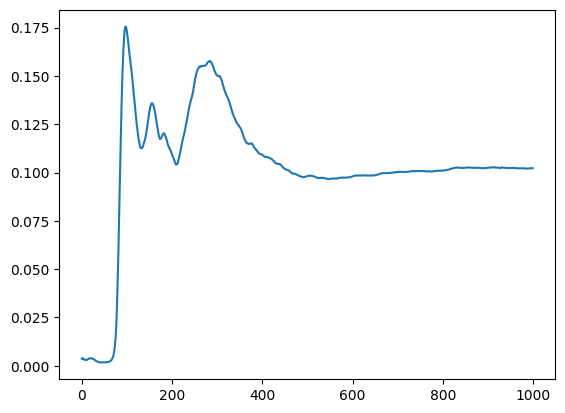

In [244]:
import matplotlib.pyplot as plt
plt.plot(h.history['classifier_accuracy']);

In [ ]:
x_train[0].shape

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses
import numpy as np

# Hiperparámetros
BATCH_SIZE = 128
EMBEDDING_DIM = 128
NUM_CLASSES = 10  # Ajustar según el dataset
TEMPERATURE = 5.0
LAMBDA = 0.5

# Función para crear el modelo CNN (similar al encoder)
def create_encoder_model(input_shape=(32, 32, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(EMBEDDING_DIM)
    ])
    return model

# Función para crear la capa de cluster
def create_cluster_model(embedding_dim=EMBEDDING_DIM, num_classes=NUM_CLASSES):
    model = models.Sequential([
        layers.Input(shape=(embedding_dim,)),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Data augmentation para imágenes
def get_data_augmentation():
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])
    return data_augmentation

# Data augmentation diferente para segundo conjunto
def get_data_augmentation_2():
    data_augmentation = keras.Sequential([
        layers.RandomFlip("vertical"),
        layers.RandomContrast(0.2),
        layers.RandomTranslation(0.1, 0.1),
    ])
    return data_augmentation

# Función de pérdida para la matriz de similitud
class ContrastiveLoss():
    def __init__(self, temperature=TEMPERATURE):
        self.temperature = temperature
        
    def __call__(self, y_pred):
        # y_true es la matriz identidad (no la usamos directamente)
        # y_pred es la matriz de similitud M
        
        # Aplicamos softmax con temperatura
        logits = y_pred / self.temperature
        logits_max = tf.reduce_max(logits, axis=1, keepdims=True)
        logits = logits - logits_max
        exp_logits = tf.exp(logits)
        exp_logits_sum = tf.reduce_sum(exp_logits, axis=1, keepdims=True)
        probs = exp_logits / exp_logits_sum
        
        # Creamos matriz identidad como objetivo
        batch_size = tf.shape(y_pred)[0]
        y_true = tf.eye(batch_size)
        
        # Calculamos entropia cruzada
        loss = -tf.reduce_sum(y_true * tf.math.log(probs + 1e-10)) / tf.cast(batch_size, tf.float32)
        return loss

# Función de pérdida para el clustering
class ClusteringLoss():
    def __init__(self):
        pass
    def __call__(self, cX_1comp, cX_2comp):

        # loss_C = cX_1comp(1 - cX_1comp) + cX_2comp(1 - cX_2comp)
        loss_1 = tf.reduce_mean(cX_1comp * (1 - cX_1comp))
        loss_2 = tf.reduce_mean(cX_2comp * (1 - cX_2comp))
        
        return loss_1 + loss_2

# Modelo combinado para entrenamiento
class ContrastiveModel(tf.keras.Model):
    def __init__(self, input_shape=(32, 32, 3), embedding_dim=EMBEDDING_DIM, num_classes=NUM_CLASSES):
        super(ContrastiveModel, self).__init__()
        self.encoder = create_encoder_model(input_shape)
        self.cluster = create_cluster_model(embedding_dim, num_classes)
        self.data_aug1 = get_data_augmentation()
        self.data_aug2 = get_data_augmentation_2()
        self.contrastive_loss = ContrastiveLoss()
        self.clustering_loss = ClusteringLoss()
        self.lambda_param = LAMBDA
        
    def compile(self, optimizer):
        super(ContrastiveModel, self).compile()
        self.optimizer = optimizer
        
    def train_step(self, data):
        # Desempaquetar los datos
        if isinstance(data, tuple):
            X = data[0]
        else:
            X = data
            
        batch_size = tf.shape(X)[0]
        
        # Aplicar las dos transformaciones de data augmentation
        augX_1 = self.data_aug1(X)
        augX_2 = self.data_aug2(X)
        
        with tf.GradientTape() as tape:
            # Obtener representaciones del encoder
            augX_1comp = self.encoder(augX_1)
            augX_2comp = self.encoder(augX_2)
            
            # Obtener salidas del clustering
            cX_1comp = self.cluster(augX_1comp)
            cX_2comp = self.cluster(augX_2comp)
            
            # Calcular matriz de similitud M
            M = tf.matmul(augX_1comp, augX_2comp, transpose_b=True)
            
            # Calcular pérdida de contraste
            loss_M = self.contrastive_loss(M)
            
            # Calcular pérdida de clustering
            loss_C = self.clustering_loss(cX_1comp, cX_2comp)
            
            # Pérdida total
            total_loss = loss_M + self.lambda_param * loss_C
            
        # Calcular gradientes y actualizar pesos
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        return {"loss": total_loss, "contrastive_loss": loss_M, "clustering_loss": loss_C}
    
    def call(self, inputs):
        # Para inferencia, solo devolvemos la representación del encoder
        return self.encoder(inputs)

# Función de utilidad para cargar y preparar dataset (ej. CIFAR-10)
def load_dataset():
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    return (x_train, y_train), (x_test, y_test)

def dummy_loss(y_true, y_pred):
    return tf.constant(0.0)

# Entrenamiento del modelo
def train_model():
    # Cargar dataset
    (x_train, y_train), (x_test, y_test) = load_dataset()
    
    # Crear modelo
    input_shape = x_train.shape[1:]
    model = ContrastiveModel(input_shape=input_shape)
    
    # Compilar el modelo
    model.compile(optimizer=keras.optimizers.Adam(1e-4))
    
    # Entrenar modelo
    model.fit(
        x_train,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(x_test, None),
        loss=dummy_loss
    )
    
    return model

# Para usar el modelo entrenado para extraer representaciones:
def extract_features(model, images):
    return model.encoder(images).numpy()

# Para clasificación, se puede entrenar un clasificador sobre las características extraídas
def train_classifier(X_features, y_labels):
    classifier = keras.Sequential([
        layers.Input(shape=(EMBEDDING_DIM,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    classifier.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    classifier.fit(X_features, y_labels, batch_size=32, epochs=10, validation_split=0.1)
    return classifier

# Ejemplo de uso completo
if __name__ == "__main__":
    # Entrenar el modelo contrastivo
    contrastive_model = train_model()
    
    # Cargar datos
    (x_train, y_train), (x_test, y_test) = load_dataset()
    
    # Extraer características
    train_features = extract_features(contrastive_model, x_train)
    test_features = extract_features(contrastive_model, x_test)
    
    # Entrenar clasificador
    classifier = train_classifier(train_features, y_train)
    
    # Evaluar
    test_loss, test_acc = classifier.evaluate(test_features, y_test)
    print(f"Test accuracy: {test_acc:.4f}")

In [ ]:
unlabeled_train[0].shape

In [11]:
one_hot_train[2]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])